# Off-policy divergence: Baird's MDP

This notebook implements an empirical proof of `off-policy` divergence using [Baird's MDP]()

> `Exercise 11.3`: Apply one-step semi-gradient Q-learning to Baird’s counterexample and show empirically that its weights diverge.
> 
> [Sutton & Barto's RL Introduction book](http://incompleteideas.net/book/RLbook2020.pdf)


<img src="https://lcalem.github.io/imgs/sutton/bairds.png" 
     alt="Sutton &amp; Barto summary chap 11 - Off-policy methods for approximation ..."
     width="650"
/>

More generally, off-policy divergence occurs when we have instances of the [Deadly Triad](https://arxiv.org/pdf/1812.02648v1.pdf):

 - **Function approximation**: (e.g., linear function approximation or ANNs)
 - **Bootstrapping**: Update targets that include existing estimates (as in dynamic programming or TD methods) rather than relying exclusively on actual rewards and complete returns (as in MC methods)
 - **Off-policy training**: Training on a distribution of transitions other than that produced by the target policy

## Parameters

In [176]:
n_states = 7
n_actions = 2
steps = 1000
step_size = 0.01  # alpha
discount_factor = 0.99  # gamma

In [173]:
import numpy as np


class BairdMDP:
    def __init__(self, n_states: int, n_actions: int):
        self.n_states = n_states
        self.n_actions = n_actions  # dashed & solid
        self.state = None

    def _random_state(self, n):
        # uniform probability over 0..n states
        return np.random.choice(np.arange(n), p=np.ones(n) * 1 / n)

    def reset(self):
        self.state = self._random_state(self.n_states)
        return self.state, {}  # state, info

    def step(self, action: int):
        if action < 0 or action > self.n_actions - 1:
            raise ValueError(f"Invalid action {action}. Not between 0 and 1")

        if action == 0:
            self.state = self._random_state(self.n_states - 1)
        elif action == 1:
            self.state = self.n_states - 1

        # next_state, reward, terminated, truncated, info
        return self.state, 0, False, False, {}

## Estimator

In [179]:
class Estimator:
    def __init__(self, n_states: int):
        # W is an R^8 vector as described in Fig. 11.2 of Sutton & Barto's book:
        # i.e.: W = (1, 1, 1, 1, 1, 1, 10, 1)
        self.weights = np.ones(n_states + 1)
        self.weights[n_states - 1] = 10
        # Value function as described inside each state in the MDP diagram
        self.features = np.eye(n_states, n_states + 1)
        self.features[:n_states, : n_states - 1] *= 2
        self.features[:, -1] = 1
        self.features[-1][-1] = 2

    def __call__(self, s: int):
        if s < 0 or s > n_states - 1:
            raise ValueError(
                f"State '{s}' out of range. Must be within 0 and {n_states - 1}"
            )
        if a < 0 or a > n_actions - 1:
            raise ValueError(
                f"Action '{a}' out of range. Must be within 0 and {n_actions - 1}"
            )

        return np.dot(self.weights, self.features[s])

    def update(self, state, reward, next_state):
        dv_dw = self.features[state]
        self.weights += (
            step_size
            * (reward + discount_factor * self(next_state) - self(state))
            * dv_dw
        )

## Off-policy TD(0) - Q-learning

  0%|          | 0/1000 [00:00<?, ?it/s]

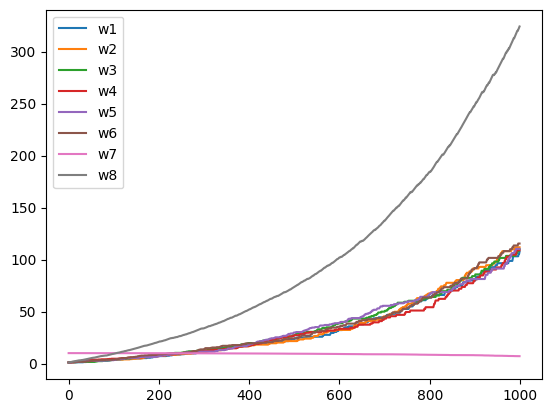

In [180]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


def b_policy(state):
    return np.random.choice(
        np.arange(n_actions), p=[(n_states - 1) / n_states, 1 / n_states]
    )


def target_policy(state):
    return 1  # always takes 'solid' action


env = BairdMDP(n_states, n_actions)
V = Estimator(n_states)

state, _ = env.reset()

ws = []
for i in tqdm(range(steps)):
    # chose action using the behaviour policy
    action = b_policy(state)
    # Take a step in the environment
    next_state, reward, terminated, truncated, _ = env.step(action)

    if terminated or truncated:
        break

    # Q learning update:
    # If we are to follow the target policy, then we always end up in state 7
    next_state = n_states - 1
    V.update(state, reward, next_state)

    # Track the weights evolution
    ws.append(V.weights.copy())

    state = next_state


# Plot the weight values over time
ws = np.array(ws)
plt.plot(ws)
plt.legend([f"w{i+1}" for i in range(ws.shape[-1])])
plt.show()